<img src='../img/LogoWekeo_Copernicus_RGB_0.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='10%'></img>

# CAMS European Air Quality Forecasts and Analyses - Nitrogen Dioxide - Explore

This notebooks provides an introduction to the CAMS European Air Quality Forecasts and Analyses and how the data can be used to monitor increased levels of `Nitrogen Dioxide` over Europe.

The notebook shows the Nitrogen Dioxide forecast from 4 February 2021 for the next three days. CAMS provides maps of daily average surface concentrations of key air pollutants, e.g. NO<sub>2</sub>, PM2.5, PM10 and Ozone. Find more information [here](https://atmosphere.copernicus.eu/air-quality).


#### Module outline:
* [1 - Load and browse the CAMS European Air Quality forecast data](#load_browse_europe)
* [2 - Retrieve the data variable Nitrogen Dioxide as xarray.DataArray](#data_retrieve_europe)
* [3 - Visualize Nitrogen Dioxide at surface over Europe](#visualize_europe)
* [5 - Animate Nitroge Dioxide levels at surface over time](#animate_europe)

<hr>

#### Load required libraries

In [1]:
import xarray as xr
from datetime import datetime
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.cm import get_cmap
from matplotlib.axes import Axes

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

#### Load helper functions

In [3]:
%run ../functions.ipynb

<hr>

### <a id='load_browse_europe'></a>Load and browse CAMS European Air Quality forecast data

CAMS global near-real-time forecast data is available either in `GRIB` or `netCDF`. The data for the present example has been downloaded in the `netCDF` format. The notebook [20_CAMS_European_air_quality_forecast_retrieve](./20_CAMS_European_air_quality_forecast_NO2_retrieve.ipynb) shows an example how to access the data with the `WEkEO HDA API`.

You can use xarray's function `xr.open_dataset()` to open the netCDF file as `xarray.Dataset`.

*Note: The file is per default downloaded with a very cryptic name starting with `adaptor.cams_regional_fc...`.  Hence, it is recommended to rename the file, e.g. to `20210204_cams_eur_fc_no2.nc`*.

In [10]:
file = xr.open_dataset('./data/20210204_cams_eur_fc_no2.nc')
file

<xarray.Dataset>
Dimensions:    (longitude: 693, latitude: 416, level: 1, time: 13)
Coordinates:
  * longitude  (longitude) float32 335.8 335.9 336.0 336.0 ... 44.75 44.85 44.95
  * latitude   (latitude) float32 71.55 71.45 71.35 71.25 ... 30.25 30.15 30.05
  * level      (level) float32 0.0
  * time       (time) timedelta64[ns] 0 days 00:00:00 ... 3 days 00:00:00
Data variables:
    no2_conc   (time, level, latitude, longitude) float32 ...
Attributes:
    title:        NO2 Air Pollutant FORECAST at the Surface
    institution:  Data produced by Meteo France
    source:       Data from ENSEMBLE model
    history:      Model ENSEMBLE FORECAST
    FORECAST:     Europe, 20210204+[0H_72H]
    summary:      ENSEMBLE model hourly FORECAST of NO2 concentration at the ...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

<br>

The data above has four dimensions (`latitude`, `longitude`, `level` and `time`) and one data variable:
* `no2_conc`: Mass concentration of Nitrogen Dioxide in the air


Let us inspect the coordinates of the file more in detail. Below, you see that the data set consists of 13 time steps, starting on 4 February 2021 00 UTC and ranging up to 3 days ahead. However, the format of the time coordinates is in nanoseconds.

Let us convert the time information into a human-readable time format.

In [11]:
file.time

<xarray.DataArray 'time' (time: 13)>
array([              0,  21600000000000,  43200000000000,  64800000000000,
        86400000000000, 108000000000000, 129600000000000, 151200000000000,
       172800000000000, 194400000000000, 216000000000000, 237600000000000,
       259200000000000], dtype='timedelta64[ns]')
Coordinates:
  * time     (time) timedelta64[ns] 0 days 00:00:00 ... 3 days 00:00:00
Attributes:
    long_name:  FORECAST time from 20210204

First, from the `long_name` information of the time dimension, we can retrieve the initial timestamp. With the function `strptime()` from Python's `datetime` library, we can convert it into a `datetime.datetime` object.

In [12]:
timestamp = file.time.long_name[19:27]

timestamp_init=datetime.strptime(timestamp,'%Y%m%d' )
timestamp_init

datetime.datetime(2021, 2, 4, 0, 0)

<br>

In a next step, we then build a `DateTimeIndex` object with the help of Panda's `date_range()` function, making use of the length of time dimension.
The result is a `DateTimeIndex` object, which can be used to newly assign the time coordinate information.

In [13]:
time_coords = pd.date_range(timestamp_init, periods=len(file.time), freq='6h').strftime("%Y-%m-%d %H:%M:%S").astype('datetime64[ns]')
time_coords


DatetimeIndex(['2021-02-04 00:00:00', '2021-02-04 06:00:00',
               '2021-02-04 12:00:00', '2021-02-04 18:00:00',
               '2021-02-05 00:00:00', '2021-02-05 06:00:00',
               '2021-02-05 12:00:00', '2021-02-05 18:00:00',
               '2021-02-06 00:00:00', '2021-02-06 06:00:00',
               '2021-02-06 12:00:00', '2021-02-06 18:00:00',
               '2021-02-07 00:00:00'],
              dtype='datetime64[ns]', freq=None)

<br>

And the last step is to assign the converted time information to the DataArray `no2_fc`, with the function `assign_coords()`.

In [14]:
no2_fc = file.assign_coords(time=time_coords)
no2_fc

<xarray.Dataset>
Dimensions:    (longitude: 693, latitude: 416, level: 1, time: 13)
Coordinates:
  * longitude  (longitude) float32 335.8 335.9 336.0 336.0 ... 44.75 44.85 44.95
  * latitude   (latitude) float32 71.55 71.45 71.35 71.25 ... 30.25 30.15 30.05
  * level      (level) float32 0.0
  * time       (time) datetime64[ns] 2021-02-04 ... 2021-02-07
Data variables:
    no2_conc   (time, level, latitude, longitude) float32 ...
Attributes:
    title:        NO2 Air Pollutant FORECAST at the Surface
    institution:  Data produced by Meteo France
    source:       Data from ENSEMBLE model
    history:      Model ENSEMBLE FORECAST
    FORECAST:     Europe, 20210204+[0H_72H]
    summary:      ENSEMBLE model hourly FORECAST of NO2 concentration at the ...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

<br>

Below, we see that the latitude and longitude values have a 0.1 degrees resolution and a European coverage. The longitude values however are on a [0, 360] grid instead of a [-180, 180] grid.

In [15]:
file.latitude, file.longitude

(<xarray.DataArray 'latitude' (latitude: 416)>
 array([71.55, 71.45, 71.35, ..., 30.25, 30.15, 30.05], dtype=float32)
 Coordinates:
   * latitude  (latitude) float32 71.55 71.45 71.35 71.25 ... 30.25 30.15 30.05
 Attributes:
     long_name:  latitude
     units:      degrees_north,
 <xarray.DataArray 'longitude' (longitude: 693)>
 array([335.75, 335.85, 335.95, ...,  44.75,  44.85,  44.95], dtype=float32)
 Coordinates:
   * longitude  (longitude) float32 335.8 335.9 336.0 336.0 ... 44.75 44.85 44.95
 Attributes:
     long_name:  longitude
     units:      degrees_east)

<br>

### <a id='shift_europe'></a>Bring longitude coordinates onto a [-180,180] grid

You can assign new values to coordinates in an `xarray.Dataset`. You can do so with the `assign_coords()` function, which you can apply onto a `xarray.Dataset`. The code below shifts your longitude grid from [0,360] to [-180,180]. At the end, you sort the longitude values in an ascending order.

In [16]:
file_assigned = no2_fc.assign_coords(longitude=(((no2_fc.longitude + 180) % 360) - 180)).sortby('longitude')
file_assigned

<xarray.Dataset>
Dimensions:    (longitude: 693, latitude: 416, level: 1, time: 13)
Coordinates:
  * longitude  (longitude) float32 -24.25 -24.15 -24.05 ... 44.75 44.85 44.95
  * latitude   (latitude) float32 71.55 71.45 71.35 71.25 ... 30.25 30.15 30.05
  * level      (level) float32 0.0
  * time       (time) datetime64[ns] 2021-02-04 ... 2021-02-07
Data variables:
    no2_conc   (time, level, latitude, longitude) float32 ...
Attributes:
    title:        NO2 Air Pollutant FORECAST at the Surface
    institution:  Data produced by Meteo France
    source:       Data from ENSEMBLE model
    history:      Model ENSEMBLE FORECAST
    FORECAST:     Europe, 20210204+[0H_72H]
    summary:      ENSEMBLE model hourly FORECAST of NO2 concentration at the ...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

<br>

A quick check of the longitude coordinates of the new `xarray.Dataset` shows you that the longitude values are now on a [-180, 180] longitude grid.

In [17]:
file_assigned.longitude

<xarray.DataArray 'longitude' (longitude: 693)>
array([-24.25    , -24.150024, -24.049988, ...,  44.75    ,  44.850006,
        44.949997], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -24.25 -24.15 -24.05 ... 44.75 44.85 44.95

### <a id='data_retrieve_europe'></a>Retrieve the Nitrogen Dioxide values as xarray.DataArray

Let us store the data variable `no2_conc` as `xarray.DataArray` with the name `no2_conc`.

In [18]:
no2_conc = file_assigned.no2_conc
no2_conc

<xarray.DataArray 'no2_conc' (time: 13, level: 1, latitude: 416, longitude: 693)>
[3747744 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -24.25 -24.15 -24.05 ... 44.75 44.85 44.95
  * latitude   (latitude) float32 71.55 71.45 71.35 71.25 ... 30.25 30.15 30.05
  * level      (level) float32 0.0
  * time       (time) datetime64[ns] 2021-02-04 ... 2021-02-07
Attributes:
    species:        Nitrogen Dioxide
    units:          µg/m3
    value:          hourly values
    standard_name:  mass_concentration_of_nitrogen_dioxide_in_air

<br>

Above, you see that the variable `no2_conc` has four attributes, `species`, `units`, `value` and `standard_name`. Let us define variables for the attributes `unit` and `standard_name`. The variables can be used during data visualisation.

In [19]:
long_name = no2_conc.standard_name
units = no2_conc.units

<br>

Let us do the same for the coordinates `longitude` and `latitude`.

In [20]:
latitude = no2_conc.latitude
longitude = no2_conc.longitude

<br>

### <a id='visualize_europe'></a>Visualisation of forecasted Nitrogen Dioxide concentration over Europe between 4-7 February 2021

The next step is to visualize the dataset. You can use the function [visualize_pcolormesh()](../functions.ipynb#visualize_pcolormesh), which makes use of matplotlib's function `pcolormesh()` and the [Cartopy](https://scitools.org.uk/cartopy/docs/latest/) library.

You can make use of the variables we have defined above:
- `units`
- `long_name`
- `latitude`
- `longitude`

Additionally, you can specify the color scale and minimum and maxium data values.

(<Figure size 2000x1000 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'mass_concentration_of_nitrogen_dioxide_in_air 2021-02-05T12:00:00.000000000'}>)

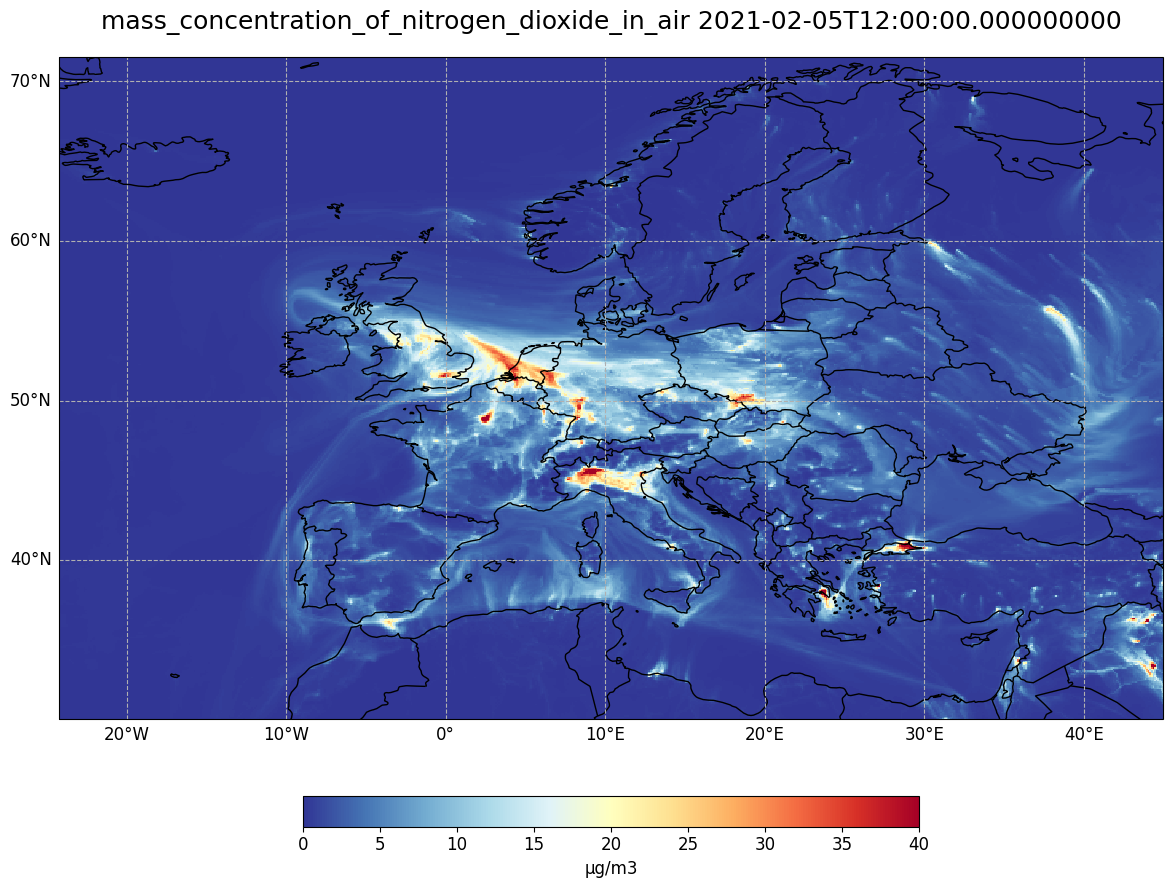

In [24]:
timestep = 6
visualize_pcolormesh(data_array=no2_conc[timestep,0,:,:],
                     longitude=longitude,
                     latitude=latitude,
                     projection=ccrs.PlateCarree(),
                     color_scale='RdYlBu_r',
                     unit=units,
                     long_name=long_name + ' ' + str(no2_conc[timestep,0,:,:].time.data),
                     vmin=0, 
                     vmax=40,
                     lonmin=longitude.min().data,
                     lonmax=longitude.max().data,
                     latmin=latitude.min().data,
                     latmax=latitude.max().data,
                     set_global=False)

<hr>